In [3]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import math 
import idx2numpy
%matplotlib inline

In [5]:
# load the data 
train_x = idx2numpy.convert_from_file('./data/train-images-idx3-ubyte')
train_y = idx2numpy.convert_from_file('./data/train-labels-idx1-ubyte')
test_x = idx2numpy.convert_from_file('./data/t10k-images-idx3-ubyte')
test_y = idx2numpy.convert_from_file('./data/t10k-labels-idx1-ubyte')

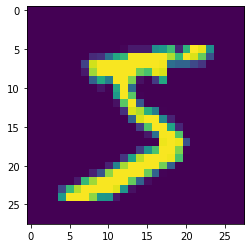

In [23]:
plt.imshow(train_x[0,:])
plt.show()

In [24]:
# Section 1 Question 2
# Sampling from a centered kernel. 

def create_kernel_matrix(kernelfunc, size, shift, diag_add):  
    # make matrix diagonally dominant.
    return np.add(np.fromfunction(lambda i, j: kernelfunc(i - shift , j - shift), (size, size)), np.identity(size) * diag_add)  

def create_normal_distribution(kernel): 
    mu, cov = np.zeros(tf.shape(kernel).numpy()[0]), tf.linalg.inv(kernel)
    scale = tf.linalg.cholesky(cov)
    return tfp.distributions.MultivariateNormalTriL(loc=mu,scale_tril=scale)

def sampleRKHS(kernelfunc, dsize=10, center=True, ssize=12, rkhs_range=(-4,4), func_precision=100, diag_add=1e-5):
    """
    kernelfunc - lambda func that defines the kernel matrix of size dsize x dsize
    dsize - number of elements in the original dataset. 
    ssize - sample size, how many functions from RKHS to sample
    rkhs_range - what range to display the RKHS functions on
    func_precision - how many points to genereate in the rkhs_range (to draw lines) i.e resolution of lines

    returns X, Y -> X: domain values with shape(func_precision, ssize) Y: y values sampled RKHS functions 
    shape(func_precision, ssize) each col represents x and y values of each sampled function. 
    """
    shift = 0
    if center: 
        shift = (dsize // 2) 

    kernel_matrix = create_kernel_matrix(kernelfunc, dsize, shift, diag_add) 
    mvn = create_normal_distribution(kernel_matrix) 
    xi = np.linspace(rkhs_range[0], rkhs_range[1], func_precision) # this will be the domain we will be looking at of the RKHS space. 

    # create a matrix that will store the domains of the sampled value (linespace).
    # each column will be the same since we are analyzing them in the same domain.  
    y = np.reshape(xi.T, (xi.shape[0], 1)) # create a transpose of x (since each col will represent the points we are eval at)
    X_f = y
    X_k = y
    for i in range (0, ssize - 1): # range == # of datums in original dataset. 
        X_f = np.concatenate((X_f, y), axis=1)
    
    for i in range(0, dsize - 1): 
        X_k = np.concatenate((X_k, y), axis=1)

    
    # create functions evaluated at the 10 different basis functions 
    # each basis function is a kernel evaluated at each point holding second variable constant. 
    # in this case we are evaluating the second variable at (almost) all possible points (large number of rows representing domain)
    Kx = np.zeros((X_k.shape[0], dsize))


    for i in range(Kx.shape[0]): 
        for j in range(Kx.shape[1]):
            Kx[i, j] = kernelfunc(j - shift, X_k[i, j]) # IndexError: index 12 is out of bounds for axis 1 with size 12
    
    
    # now create the weighted functions now representing the actual functions in RKHS. 
    alphas = mvn.sample([ssize]).numpy() # sample the alpha weights by which each kernel function will be weighed. 
    # each fx will need its own alpha. Amount sampled is the amount of sample functions we want to generate. 
    Fx = np.matmul(Kx, alphas.T)
    return X_f, Fx